In [7]:
import jax
import jax.numpy as jnp
from PIL.ImageChops import offset
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt

import numpy as np
from qtconsole.mainwindow import background
from scipy.stats import alpha
from zmq import WSS_KEY_PEM

from Utils.models import *
from Utils.simulation import *
from Utils.plot_utils import *

import time
from copy import copy


%load_ext autoreload
%autoreload 2

params_dict = {
    "dataset_parameters": {
        "n_samples": 200
    },
    "network_parameters": {
        "input_size": 64,
        "hidden_size": 128,
        "output_size": 1,
        "bias": 1,
    },
    "training_parameters": {
        "num_epochs": 100,
        "learning_rate": 0.01
    },
    "simulation_parameters": {
        "mu": 1,
        "sigma": 0.1,
        "theta": 0.02,
        "dt": 0.0005,
        "tau": 0.002
    },
    "seed": 42
}


# set the random key
rng = random.PRNGKey(params_dict["seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
simulation_parameters = params_dict['simulation_parameters']

asymptotic_variance(**simulation_parameters)

0.3333333333333334

In [9]:
mu = simulation_parameters['mu']
sigma = simulation_parameters['sigma']
theta = simulation_parameters['theta']
dt = simulation_parameters['dt']
tau = simulation_parameters['tau']


The formula for the variance is

$$
V = \frac{\mu^2 \sigma^2}{2\theta - \sigma^2}
$$

which means that given a $\theta$ and a desired $V$ we have

$$
\sigma = \sqrt{\frac{2\theta V}{\mu^2 + V }}
$$

In [10]:
desired_var = asymptotic_variance(**simulation_parameters)
theta = 0.08

sigma = jnp.sqrt(2*theta*desired_var/ (mu**2 + desired_var))
print(sigma)

0.2


In [11]:
simulation_parameters["theta"] = theta
simulation_parameters["sigma"] = sigma

In [12]:
# mean and sigma of the lognormal distribution from the paramaters
mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])



#initialize the 2 layer ELM
rng, net_key = random.split(rng)
params = init_elm(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

print("mean = ", jnp.mean(params['W_i']))
print("variance = ", jnp.var(params['W_i']))

rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key,
                                         n_samples=params_dict["dataset_parameters"]["n_samples"],
                                         input_dim=params_dict["network_parameters"]["input_size"])

simulation_parameters = params_dict["simulation_parameters"]
training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]


# sigma = simulation_parameters["sigma"]
# theta = simulation_parameters["theta"]
dt = simulation_parameters["dt"]
tau = simulation_parameters["tau"]

mu = jnp.ones_like(params["W_i"])*simulation_parameters["mu"]
rate = 0.01

loss_list = []
acc_list = []
weight_list = []
mu_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in zip(X_train,y_train):

        rng, gou_key = random.split(rng)
        #perturb the weights of W_i
        params['W_i'] = time_evolution_GOU(gou_key, params['W_i'], mu, theta, sigma, tau, dt )

        grads = grad(loss_elm)(params, x, y)

        params['W_i'] -= learning_rate * grads['W_i']
        params['W_o'] -= learning_rate * grads['W_o']
        params['b_i'] -= learning_rate * grads['b_i']
        params['b_o'] -= learning_rate * grads['b_o']

        mu += rate * (params['W_i'] - mu)
        weight_list.append(params['W_i'].flatten())
        mu_list.append(mu.flatten())

    acc_list.append(accuracy_elm(params, X_train, y_train))
    loss_list.append(loss_elm(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss_elm(params, X_train, y_train)
        train_acc = accuracy_elm(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))

mean =  1.0048445
variance =  0.31889585
Epoch 0 in 2.52 sec
Training set loss 1.1662031412124634
Training set accuracy 0.5349999666213989
Epoch 10 in 1.00 sec
Training set loss 0.6453988552093506
Training set accuracy 0.7299999594688416


KeyboardInterrupt: 

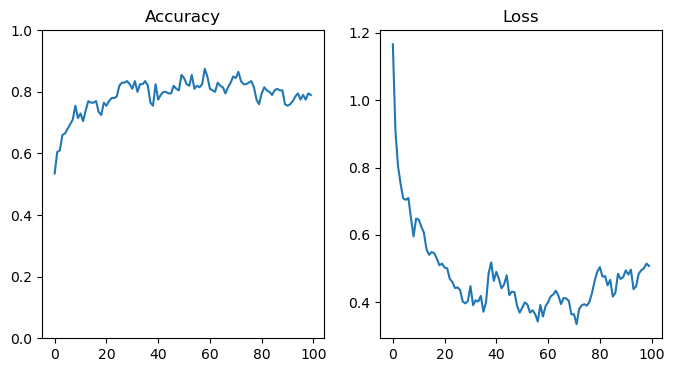

In [7]:
#plot the accuracy and loss

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(acc_list)
axs[0].set_title("Accuracy")
axs[0].set_ylim([0,1])

axs[1].plot(loss_list)
axs[1].set_title("Loss")
plt.show()


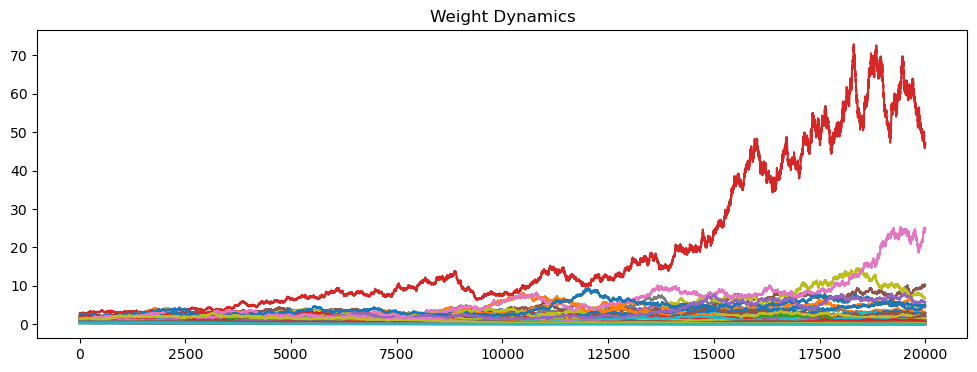

In [8]:
plot_weight_dynamics(np.array(weight_list), title="Weight Dynamics", weights_to_show=100, show=True)

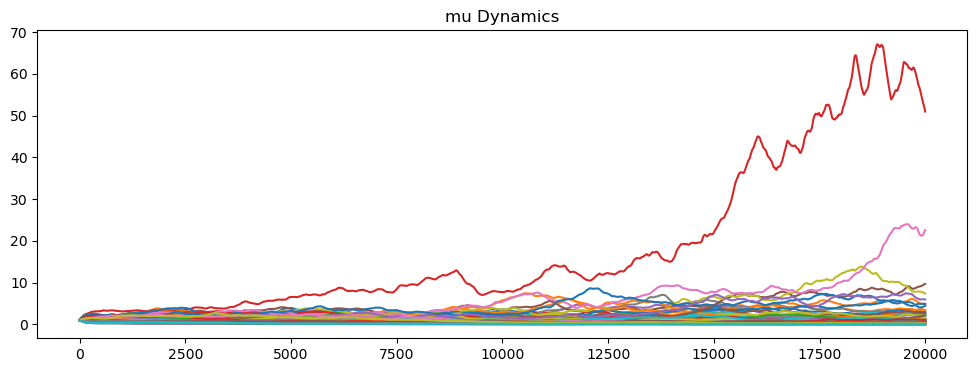

In [9]:
plot_weight_dynamics(np.array(mu_list), title="mu Dynamics", weights_to_show=100, show=True)

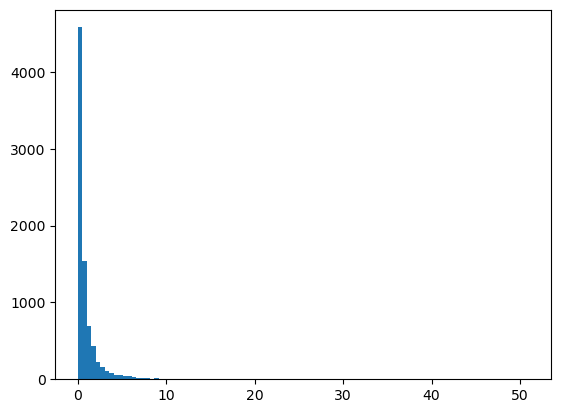

In [10]:
plt.hist(mu.flatten(), bins=100)
plt.show()

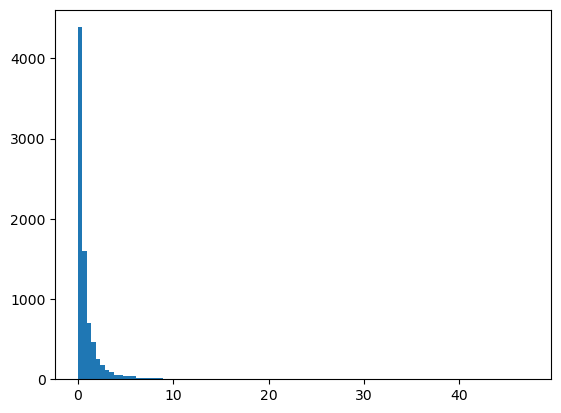

In [11]:
plt.hist(params["W_i"].flatten(), bins=100)
plt.show()

In [12]:
test_loss_list = []
test_acc_list = []
test_weight_list = []
test_mu_list = []

for epoch in range(num_epochs*2):
    for x,y in zip(X_train,y_train):

        rng, gou_key = random.split(rng)
        #perturb the weights of W_i
        params['W_i'] = time_evolution_GOU(gou_key, params['W_i'], mu, theta, sigma, tau, dt )

        test_weight_list.append(params['W_i'].flatten())
        test_mu_list.append(mu.flatten())

    test_acc_list.append(accuracy_elm(params, X_train, y_train))
    test_loss_list.append(loss_elm(params, X_train, y_train))


    if epoch%10==0:
        train_loss = loss_elm(params, X_train, y_train)
        train_acc = accuracy_elm(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))

Epoch 0 in 1.06 sec
Training set loss 0.5952056646347046
Training set accuracy 0.7450000047683716
Epoch 10 in 1.06 sec
Training set loss 0.7925018072128296
Training set accuracy 0.6649999618530273
Epoch 20 in 1.06 sec
Training set loss 0.7557185888290405
Training set accuracy 0.6899999976158142
Epoch 30 in 1.06 sec
Training set loss 0.9728115797042847
Training set accuracy 0.5999999642372131
Epoch 40 in 1.06 sec
Training set loss 0.9016476273536682
Training set accuracy 0.6399999856948853
Epoch 50 in 1.06 sec
Training set loss 0.8476226329803467
Training set accuracy 0.6649999618530273
Epoch 60 in 1.06 sec
Training set loss 0.9737877249717712
Training set accuracy 0.6349999904632568
Epoch 70 in 1.06 sec
Training set loss 1.0148794651031494
Training set accuracy 0.6399999856948853
Epoch 80 in 1.06 sec
Training set loss 1.0562485456466675
Training set accuracy 0.6499999761581421
Epoch 90 in 1.06 sec
Training set loss 1.112709641456604
Training set accuracy 0.6549999713897705
Epoch 100 in

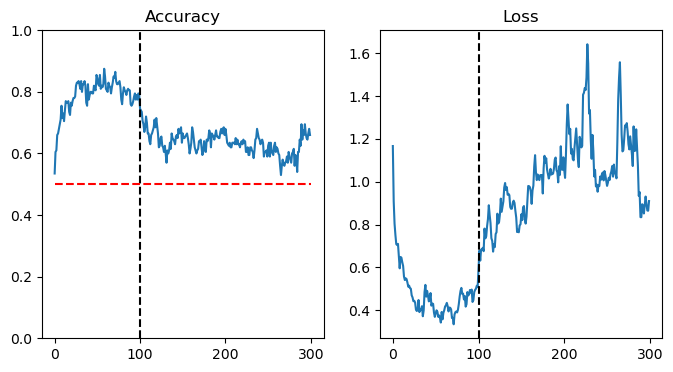

In [13]:
tot_loss_list =  loss_list + test_loss_list
tot_acc_list = acc_list + test_acc_list


fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(tot_acc_list)
axs[0].set_title("Accuracy")
axs[0].set_ylim([0,1])
axs[0].axvline(x=num_epochs, color='k', linestyle='--')
#plot a horizontal line
axs[0].hlines(0.5,xmin=0, xmax=len(tot_acc_list), color='r', linestyle='--')

axs[1].plot(tot_loss_list)
axs[1].set_title("Loss")
axs[1].axvline(x=num_epochs, color='k', linestyle='--')

#plt.savefig("weak_weights_adapt.png")
plt.show()
